In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
scripts_path = os.path.abspath(os.path.join('../scripts'))
if scripts_path not in sys.path:
    sys.path.insert(0,scripts_path)

In [3]:
from station_location import *

In [4]:
TRAIN_SET = '../data/downloads/train/'
TEST_SET = '../data/downloads/test/'
TRUE_VALUES_SETS = ['../data/catalog_2018.csv', '../data/catalog_2019.csv']
ANTENNA_INDEX = 0
SPS_INDEX = 2
START_TIME_INDEX = 3
TIME_WINDOW = 10
WAIT_TIME_WINDOW = 5
NUM_DAY_PER_DIR = 15

In [5]:
# Assuming what is computed here is common to test and train
header = pd.read_csv(TRAIN_SET+'1/0.slist', sep='\t', nrows=0).columns[0].split(', ')

# Number of samples per second
sps = int(re.findall(r'\d+', header[SPS_INDEX])[0])
# Number of samples per windows
spw = (TIME_WINDOW + WAIT_TIME_WINDOW) * sps

# Antenna
antenna = header[ANTENNA_INDEX].split(' ')[1].split('_')
network = antenna[0]
station = antenna[1]
channel = antenna[3]

latitude, longitude, elevation = get_location(network, station, channel)

In [6]:
latitude, longitude, elevation

(35.79657, -97.454857, 333.0)

In [7]:
compute_distance(latitude, longitude, elevation, latitude, longitude, -5645)

5978.000000000265

In [8]:
compute_distance(latitude, longitude, elevation, 36.45094, -98.79978, -5645)

141239.64380985397

In [9]:
def gaussian_interpolation(v1, v2, nb_missing_values, mean=0, std=300, sample_freq=sps):
    x = [0, nb_missing_values]
    f_x = [v1, v2]
    missing_times = np.linspace(0, nb_missing_values - 1, nb_missing_values)
    interp_v = np.interp(missing_times, x, f_x)
    noise = np.random.normal(mean, std, nb_missing_values)
    return interp_v + noise

def load_data(data_path, dirs='all'):
    if dirs == 'all':
        dirs = !ls -v $data_path 
    
    """Kernel restarting from ~ 7 chunks of 15 days"""
    X = np.array([])
    for i_dir, d in enumerate(dirs):
        print(f"Loading days {15*i_dir+1} to {15*(i_dir+1) - 1}")
        dir_path = os.path.join(data_path+'/', d)
        if i_dir == 0:
            first_trace_header = pd.read_csv(dir_path+'/'+'0.slist', sep='\t', nrows=0).columns[0].split(', ')
            train_start_time = pd.to_datetime(first_trace_header[START_TIME_INDEX])
        
        first_trace_header = pd.read_csv(dir_path+'/'+'0.slist', sep='\t', nrows=0).columns[0].split(', ')
        dir_start_time = pd.to_datetime(first_trace_header[START_TIME_INDEX])

        dir_X = np.array([])
        all_slists = !ls -v $dir_path
        for slist in all_slists:
            
            # Compute size of padding
            slist_full_path = os.path.join(dir_path, slist)
            header = pd.read_csv(slist_full_path, sep='\t', nrows=0).columns[0].split(', ')
            time_elapsed =  pd.to_datetime(header[START_TIME_INDEX]) - dir_start_time
            num_elem_elapsed = int(time_elapsed.total_seconds() * sps)
            num_elem_padd = num_elem_elapsed - dir_X.shape[0]

            # Extract data in current file
            new_X = pd.read_csv(slist_full_path, sep='\t', header=0, names=["1", "2", "3", "4", "5", "6"])
            new_X = new_X.to_numpy().reshape(-1)
            new_X = new_X[~(np.isnan(new_X))]

            # Add interpolated padding and new data
            prev = dir_X[-1] if dir_X.shape[0] != 0 else 0
            value_interpol = (prev + new_X[0]) / 2
            gaussian_padding = gaussian_interpolation(value_interpol, value_interpol, num_elem_padd)
            dir_X = np.concatenate((dir_X,gaussian_padding))
            dir_X = np.concatenate((dir_X, new_X))
        X = np.concatenate((X, dir_X))
        print(X.shape[0])
        mean_prev = np.mean(X[-100:])
        num_elem_padd_dir = np.max([(i_dir+1)*NUM_DAY_PER_DIR*24*3600*100 - X.shape[0], 0])
        X = np.concatenate((X, gaussian_interpolation(mean_prev, mean_prev, num_elem_padd_dir)))
            
    return X, train_start_time

In [10]:
catalog = pd.DataFrame()
for ys in TRUE_VALUES_SETS:
     catalog = catalog.append(pd.read_csv(ys))
catalog["origintime"] = pd.to_datetime(catalog["origintime"])
catalog.sort_values("origintime", inplace=True)
catalog

,event_id,origintime,magnitude,magnitude_source,max_mmi,latitude,longitude,depth_km,err_lat,err_lon,err_depth,err_origintime,state,county,status
0,0,2018-01-01 01:43:55,2.0,OGS,0,36.880480,-97.927090,5.953,0.30,0.40,0.70,0.34,None,GRANT,None
1,0,2018-01-01 03:39:47,1.9,OGS,0,36.880650,-97.931490,5.602,0.70,0.70,1.60,0.38,None,GRANT,None
2,0,2018-01-01 04:06:26,1.9,OGS,0,36.845090,-97.703160,7.647,0.60,0.60,1.40,0.44,None,GRANT,None
3,0,2018-01-01 05:29:18,2.0,OGS,0,36.150520,-97.668760,5.000,0.30,0.40,0.80,0.35,None,LOGAN,None
4,0,2018-01-01 05:46:00,2.3,OGS,0,36.152550,-97.658960,5.345,0.30,0.30,0.80,0.39,None,LOGAN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,19064,2019-11-05 07:37:36,1.9,OGS,None,36.301000,-98.188833,7.890,0.14,0.14,0.40,None,Oklahoma,Blaine,Reviewed
2821,19070,2019-11-05 07:41:35,1.5,OGS,None,35.825167,-98.097833,6.220,0.21,0.21,0.50,None,Oklahoma,Canadian,Reviewed
2822,19062,2019-11-05 11:03:56,3.1,OGS,None,36.702500,-97.661667,7.380,0.14,0.14,0.40,None,Oklahoma,Grant,Reviewed
2823,19086,2019-11-05 17:08:18,1.4,OGS,None,36.204667,-97.049667,7.560,0.28,0.28,0.50,None,Oklahoma,Payne,Reviewed


In [18]:
# 2018-04-09 10:22:20
dist_1 = 49470.577600 
time_1 = 9.039
speed_1 = dist_1/time_1

# 2018-04-12 23:56:07
dist_2 = 117930.839431
time_2 = 20.283
speed_2 = dist_2/time_2

# 2018-04-11 23:37:03
dist_3 = 33191.937156
time_3 = 5.78
speed_3 = dist_3/time_3

speed_average = (speed_1 + speed_2 + speed_3)/3

#http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html
print(f"Speed 1: {speed_1}m/s")
print(f"Speed 2: {speed_2}m/s")
print(f"Speed 3: {speed_3}m/s")
print(f"Average speed: {speed_average}m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html")

Speed 1: 5473.0144485009405m/s
Speed 2: 5814.270050337721m/s
Speed 3: 5742.5496809688575m/s
Average speed: 5676.611393269173m/s, which is in the same order of magnitude as said here: http://eqseis.geosc.psu.edu/cammon/HTML/Classes/IntroQuakes/Notes/waves_and_interior.html


In [19]:
def change_time_according_to_station(catalog, lat_station, lon_station, alt_station, speed_average):
    catalog["distance"] = catalog.loc[:, ["latitude", "longitude", "depth_km"]].apply(lambda row: compute_distance(lat_station, lon_station, alt_station, row[0], row[1], -1000*row[2]), axis=1)
    catalog["time_diff"] = catalog["distance"].map(lambda dist: dist/speed_average)
    catalog["origintime"] = catalog.loc[:, ["origintime", "time_diff"]].apply(lambda row: row[0] + pd.to_timedelta(row[1], unit='s'), axis=1)

In [20]:
change_time_according_to_station(catalog, latitude, longitude, elevation, speed_average)
catalog

,event_id,origintime,magnitude,magnitude_source,max_mmi,latitude,longitude,depth_km,err_lat,err_lon,err_depth,err_origintime,state,county,status,distance,time_diff
0,0,2018-01-01 01:44:39.965356870,2.0,OGS,0,36.880480,-97.927090,5.953,0.30,0.40,0.70,0.34,None,GRANT,None,127625.428558,22.482678
1,0,2018-01-01 03:40:32.013304488,1.9,OGS,0,36.880650,-97.931490,5.602,0.70,0.70,1.60,0.38,None,GRANT,None,127761.518551,22.506652
2,0,2018-01-01 04:07:07.808320946,1.9,OGS,0,36.845090,-97.703160,7.647,0.60,0.60,1.40,0.44,None,GRANT,None,118664.795510,20.904160
3,0,2018-01-01 05:29:33.524864466,2.0,OGS,0,36.150520,-97.668760,5.000,0.30,0.40,0.80,0.35,None,LOGAN,None,44064.311252,7.762432
4,0,2018-01-01 05:46:15.477290468,2.3,OGS,0,36.152550,-97.658960,5.345,0.30,0.30,0.80,0.39,None,LOGAN,None,43929.281701,7.738645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,19064,2019-11-05 07:38:06.644900858,1.9,OGS,None,36.301000,-98.188833,7.890,0.14,0.14,0.40,None,Oklahoma,Blaine,Reviewed,86979.596680,15.322450
2821,19070,2019-11-05 07:41:55.624480966,1.5,OGS,None,35.825167,-98.097833,6.220,0.21,0.21,0.50,None,Oklahoma,Canadian,Reviewed,58538.581816,10.312240
2822,19062,2019-11-05 11:04:32.099779670,3.1,OGS,None,36.702500,-97.661667,7.380,0.14,0.14,0.40,None,Oklahoma,Grant,Reviewed,102462.210285,18.049890
2823,19086,2019-11-05 17:08:38.674929510,1.4,OGS,None,36.204667,-97.049667,7.560,0.28,0.28,0.50,None,Oklahoma,Payne,Reviewed,58681.770204,10.337465


In [28]:
catalog = catalog[catalog['magnitude'] >= 3.5]

In [29]:
def count_signs_per_row(X, amplitude):
    X = X - np.mean(X, axis=1).reshape(X.shape[0], 1)
    first_kernel = X[:,1:]
    second_kernel = X[:,:-1]
    change_of_sign = first_kernel * second_kernel
    
    return np.sum(change_of_sign < -amplitude, axis=1).reshape(X.shape[0], 1)

In [30]:
def weighted_sliding_mean_per_row(X, mean_size):
    N, W = X.shape
    diff = np.abs(X[:, 1:] - X[:, :-1])
    diff = diff[:, mean_size-1:]
    
    diff_sliding_mean = np.zeros((N, W - (mean_size - 1)))
    for i, w in enumerate(X):
        diff_sliding_mean[i] = np.abs(np.convolve(w, np.ones(mean_size), 'valid') / mean_size)
    weighted_diff = diff / (diff_sliding_mean[:,:-1] + 1)
    
    return np.max(weighted_diff, axis=1).reshape((N, 1))

In [31]:
def basic_features(X):
    N = X.shape[0]
    
    f_1 = np.std(X, axis=1).reshape((N, 1))
    f_2 = np.max(X, axis=1).reshape((N, 1))
    f_3 = np.min(X, axis=1).reshape((N, 1))
    X_mean = X - np.mean(X, axis=1).reshape((N, 1))
    f_4 = np.max(X_mean[:,:-1] - X_mean[:,1:], axis=1).reshape((N, 1))
    f_5 = np.max(X_mean, axis=1).reshape((N, 1))
    f_6 = np.min(X_mean, axis=1).reshape((N, 1))
    f_7 = np.sum(X_mean > f_5/2, axis=1).reshape((N, 1))
    f_8 = np.sum(X_mean < f_6/2, axis=1).reshape((N, 1))
    
    return np.hstack((f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8))

In [32]:
def fourier_features(X, min_freq):
    # Number of samplepoints
    N = X.shape[0]

    # sample spacing
    T = 1.0 / 200 # Want frequency until 100hz
    
    X = X - np.mean(X, axis=1).reshape((N, 1))
    xf = np.fft.fft(X, axis=1)
    x_amplitudes = 2.0/N * np.abs(xf[:, :N//2])
    medians = np.median(x_amplitudes, axis=1).reshape(N, 1)
    means = np.mean(x_amplitudes[:, min_freq:], axis=1).reshape(N, 1)
    
    split_1 = int(x_amplitudes.shape[1]/5) # 20hz
    split_2 = int(x_amplitudes.shape[1]/40) # 2.5hz
    
    f_1 = np.std(x_amplitudes[:,split_1:],axis=1).reshape(N,1)
    f_2 = np.std(x_amplitudes[:,split_2:split_1],axis=1).reshape(N,1)
    f_3 = np.mean(x_amplitudes[:,split_2:split_1],axis=1).reshape(N,1)
    
    return np.hstack((medians, means, f_1, f_2, f_3))

In [33]:
def compute_end_time(X, start_time):
    total_number_of_seconds = (X.shape[0] - 1) / sps # First sample is at starting time -> subtract 1
    end_time = start_time + pd.to_timedelta(total_number_of_seconds, unit='s')

    return end_time

def compute_X_and_y(filename, sps, catalog, amplitude, dirs='all'):
    X, start_time = load_data(filename, dirs=dirs)
    end_time  = compute_end_time(X, start_time)
    
    catalog = catalog[(catalog["origintime"] >= start_time) & (catalog["origintime"] <= end_time)]
    
    
    N = X.shape[0]
    print(f"Number of points {N}")
    window_size = TIME_WINDOW*sps
    number_window = np.math.floor(N / window_size)
    X = X[:number_window*window_size]
    X_time_window = X.reshape(number_window, window_size)
    print(f"X shape {X_time_window.shape}")
    
    y = np.zeros((X_time_window.shape[0], 1))
    
    for date in catalog["origintime"]:
        seconds_to_eq = (date - start_time).total_seconds()
        index_in_data = seconds_to_eq * sps
        index = int(index_in_data / window_size)
        y[index] = 1
    
    feature1 = count_signs_per_row(X_time_window, amplitude)
    feature2 = weighted_sliding_mean_per_row(X_time_window, 25)
    feature3_7 = fourier_features(X_time_window, 30)
    feature8_15 = basic_features(X_time_window)
    
    #time_sta:mps = pd.Series([start_time + pd.to_timedelta(i * (total_window_size / sps), unit='s') for i in range(X_time_window.shape[0])])
    
    return X_time_window, np.hstack((feature1, feature2, feature3_7, feature8_15)), y, start_time, end_time

In [19]:
#X_train_raw,X_train,y_train, start_time, end_time = compute_X_and_y(TRAIN_SET, sps, catalog, 100000, dirs=['9','10','11','12'])
#pd.DataFrame(X_train_raw).to_hdf('../processed-data/raw_X_train_9_to_12.hdf', 'main')
#pd.DataFrame(X_train).to_csv('../processed-data/X_train_9_to_12.csv')
#pd.DataFrame(y_train).to_csv('../processed-data/y_train_9_to_12.csv')
#pd.DataFrame([start_time, end_time]).to_csv('../processed-data/meta_9_to_12.csv')

In [34]:
raw, X_train, y_train, start, end = compute_X_and_y(TRAIN_SET, sps, catalog, 100000, dirs=['1','2','3', '4'])

Loading days 1 to 14
129600001
Loading days 16 to 29
259200001
Loading days 31 to 44
388800002
Loading days 46 to 59
518400003
Number of points 518400003
X shape (518400, 1000)


In [21]:
pd.DataFrame(raw).to_hdf('../processed-data/new/raw_X_train_5_to_8_with_basic.hdf', 'master')
pd.DataFrame(X_train).to_csv('../processed-data/new/X_train_5_to_8_with_basic.csv')
pd.DataFrame(y_train).to_csv('../processed-data/new/y_train_5_to_8_with_basic.csv')
pd.DataFrame([start, end]).to_csv('../processed-data/new/meta_5_to_8_with_basic.csv')

In [27]:
X_train = pd.read_csv('../processed-data/new/X_train_1_to_4.csv', index_col=0).to_numpy()
y_train = pd.read_csv('../processed-data/new/y_train_1_to_4.csv', index_col=0).to_numpy()

In [30]:
print(f"Number of aggregated sample:\n\tTraining {X_train.shape[0]}\n\tTesting  {X_test.shape[0]}")

Number of aggregated sample:
	Training 239259
	Testing  59815


## Training

In [29]:
y_train = y_train.reshape(-1,)

In [30]:
X_train_knn = np.vstack((X_train, X_train[y_train==1], X_train[y_train==1], X_train[y_train==1], X_train[y_train==1]))

In [31]:
y_train.shape

(414720,)

In [32]:
np.ones(np.sum(y_train==1)).shape

(369,)

In [33]:
y_train_knn = np.hstack((y_train, np.ones(np.sum(y_train==1)), np.ones(np.sum(y_train==1)), np.ones(np.sum(y_train==1)), np.ones(np.sum(y_train==1))))

In [34]:
X_train_knn.shape

(416196, 15)

In [35]:
y_train_knn.shape

(416196,)

In [24]:
from sklearn.model_selection import train_test_split
#ind = np.arange(X_train_knn.shape[0])
#np.random.shuffle(ind)
X_train_k = X_train
y_train_k = y_train

X_train, X_test, y_train, y_test = train_test_split(X_train_k, y_train_k, test_size=0.2)

In [22]:
X_test = pd.read_csv('../processed-data/new/X_train_1_to_4_with_basic.csv', index_col=0).to_numpy()
y_test = pd.read_csv('../processed-data/new/y_train_1_to_4_with_basic.csv', index_col=0).to_numpy()

In [23]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((86400, 15), (86400, 1), (86400, 15), (86400, 1))

In [37]:
knn = KNeighborsClassifier(3, n_jobs=4)
knn.fit(X_train_knn, y_train_knn)
predict(knn)

Predicted earthquakes: 679
Train Accuracy: 0.9992525077160493
Train Precision: 0.5434462444771723
Train Recall: 1.0
Train F1 score: 0.7041984732824428

Predicted earthquakes: 153
Test Accuracy: 0.9977237654320987
Test Precision: 0.013071895424836602
Test Recall: 0.022988505747126436
Test F1 score: 0.016666666666666666


In [30]:
pred = knn.predict(X_test[:10000])

In [32]:
show_accuracy(pred, y_test[:10000], "Test")

Predicted earthquakes: 57
Test Accuracy: 0.9894
Test Precision: 0.07017543859649122
Test Recall: 0.07017543859649122
Test F1 score: 0.07017543859649122


In [56]:
y_train.shape

(70579,)

In [55]:
y_test.shape

(17645,)

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

def show_accuracy(pred, true, set_):
    print(f"Predicted earthquakes: {pred[pred==1].shape[0]}")
    print(f"{set_} Accuracy: {accuracy_score(true, pred)}")
    print(f"{set_} Precision: {precision_score(true, pred)}")
    print(f"{set_} Recall: {recall_score(true, pred)}")
    print(f"{set_} F1 score: {f1_score(true, pred)}")
    
def predict(model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    show_accuracy(pred_train, y_train, "Train")
    print("")
    show_accuracy(pred_test, y_test, "Test")

In [38]:
X_train_save, y_train_save = X_train, y_train

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print("proportion of earthquake: \n\ttrain: ", y_train.sum()/y_train.shape[0]*100, "%","\n\ttest", y_test.sum()/y_test.shape[0]*100, "%")

print("RF:")
for (d, w, c) in [[40, {0: 1, 1: 10000}, 100], [30,{0: 1, 1: 100000}, 150], [40, {0: 1, 1: 100000}, 30]]:
    print("\nParam: ", d, w, c)
    rfc = RandomForestClassifier(max_depth=d, class_weight=w, n_jobs=4)
    rfc.fit(X_train, y_train.ravel())
    predict(rfc)

#print("KNN:")
#for k in [1, 2, 3, 4, 5]:
#    print("\nParams: ", k)
#    knn_model = KNeighborsClassifier(k, n_jobs=3)
#    knn_model.fit(X_train, y_train.ravel())
#    predict(knn_model)

proportion of earthquake: 
	train:  0.00150704089506 % 
	test 0.0024112654321 %
RF:

Param:  40 {0: 1, 1: 10000} 100
Predicted earthquakes: 5
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0
Test results
Predicted earthquakes: 0
Test Accuracy: 0.999975887345679
Test Precision: 0.0


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Recall: 0.0
Test F1 score: 0.0

Param:  30 {0: 1, 1: 100000} 150
Predicted earthquakes: 5
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0
Test results
Predicted earthquakes: 0
Test Accuracy: 0.999975887345679


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision: 0.0
Test Recall: 0.0
Test F1 score: 0.0

Param:  40 {0: 1, 1: 100000} 30
Predicted earthquakes: 5
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0
Test results
Predicted earthquakes: 0
Test Accuracy: 0.999975887345679
Test Precision: 0.0
Test Recall: 0.0
Test F1 score: 0.0


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
display(pd.DataFrame(X_train_save)[y_train_save == 1])
pd.DataFrame(X_train_save)[y_train_save == 0].sort_values(1, ascending=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
15024,159.0,1.348532,0.197809,0.511904,0.632921,0.908594,1.162784,7541.264688,12988.000000,-41406.000000,13938.000000,30426.824000,-23967.176000,31.0,61.0
104065,156.0,5766.619318,0.813158,1.693555,1.927070,2.590021,3.829197,23258.079953,85039.000000,-104592.000000,69372.000000,93612.987000,-96018.013000,28.0,28.0
185314,159.0,3.396647,0.180028,0.441571,0.506460,0.710112,0.971897,6146.049267,21797.000000,-36001.000000,13509.000000,30259.091000,-27538.909000,20.0,27.0
305406,223.0,70.453080,0.330127,1.120209,1.697962,1.630136,2.336311,19704.271682,118936.000000,-102825.000000,45150.000000,127882.197000,-93878.803000,10.0,19.0
305435,185.0,17.686844,0.207455,0.500056,0.752207,1.144084,1.072786,8707.714061,33507.000000,-53661.000000,13457.000000,42512.428000,-44655.572000,14.0,16.0
358444,156.0,443.067847,0.236604,0.932840,1.326880,1.985274,2.232043,15324.194864,119694.000000,-80850.000000,45128.000000,128528.697000,-72015.303000,8.0,15.0
402252,119.0,1.963214,0.068284,0.297763,0.435225,0.526909,0.685090,5029.925949,6771.000000,-23664.000000,6120.000000,15349.936000,-15085.064000,73.0,60.0
470858,108.0,0.169655,0.035043,0.035702,0.017298,0.018156,0.037130,326.247481,-7256.187185,-9202.135992,1230.957446,962.956393,-982.992414,68.0,67.0
511625,163.0,299.173402,0.410436,1.315284,1.691316,2.405530,2.990625,19950.817543,137868.000000,-130543.000000,48112.000000,144475.068000,-123935.932000,10.0,9.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
511626,228.0,10197.413793,0.473968,0.920894,0.963008,1.126410,1.953647,11924.285816,43253.0,-41813.0,28857.0,49930.407,-35135.593,23.0,66.0
508629,329.0,2969.594595,0.053843,0.102129,0.122698,0.022556,0.031083,1264.388851,7898.0,-8362.0,13920.0,7426.898,-8833.102,8.0,7.0
305407,182.0,1255.257511,0.598708,1.135731,1.410688,1.430007,2.208207,17044.837069,52334.0,-62680.0,33461.0,61328.035,-53685.965,40.0,48.0
36908,4.0,1092.261905,0.007082,0.013776,0.041263,0.005062,0.005915,438.170359,2294.0,-1101.0,1625.0,1381.525,-2013.475,15.0,9.0
9025,51.0,970.192308,0.020081,0.025483,0.023993,0.012556,0.017146,285.741573,1869.0,-1790.0,3096.0,1988.191,-1670.809,6.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6749,0.0,0.002214,0.001339,0.002444,0.013812,0.002378,0.002745,144.989592,-23483.0,-24098.0,53.0,310.511,-304.489,155.0,186.0
144693,0.0,0.002170,0.001524,0.002820,0.014279,0.003051,0.003826,150.200594,-27431.0,-28109.0,60.0,383.425,-294.575,147.0,178.0
144653,0.0,0.002169,0.001406,0.002677,0.006530,0.003939,0.004321,71.362121,-28302.0,-28649.0,59.0,178.704,-168.296,128.0,145.0
193624,0.0,0.001849,0.099637,0.246209,1.284151,0.173470,0.273340,13541.318484,-62838.0,-105716.0,97.0,14280.913,-28597.087,497.0,213.0


In [37]:
for (d, w) in [[10, {0: 0.01, 1: 0.99}], [17, {0: 0.01, 1: 0.99}], [21, {0: 0.01, 1: 0.99}], [25, {0: 0.01, 1: 0.99}],
              [10, {0: 0.001, 1: 0.999}], [17, {0: 0.001, 1: 0.999}], [21, {0: 0.001, 1: 0.999}], [25, {0: 0.001, 1: 0.999}],
              [10, {0: 0.0001, 1: 0.9999}], [17, {0: 0.0001, 1: 0.9999}], [21, {0: 0.0001, 1: 0.9999}], [25, {0: 0.0001, 1: 0.9999}]]:
    rfc = RandomForestClassifier(max_depth=d, class_weight=w, n_jobs=4)
    rfc.fit(X_train, y_train.ravel())
    predict(rfc)

Predicted earthquakes: 850
Train Accuracy: 0.9908857142857143
Train Precision: 0.3423529411764706
Train Recall: 0.7864864864864864
Train F1 score: 0.4770491803278689

Predicted earthquakes: 83
Test Accuracy: 0.9923780487804879
Test Precision: 0.26506024096385544
Test Recall: 0.2558139534883721
Test F1 score: 0.26035502958579887
Predicted earthquakes: 377
Train Accuracy: 0.9999
Train Precision: 0.9814323607427056
Train Recall: 1.0
Train F1 score: 0.9906291834002677

Predicted earthquakes: 11
Test Accuracy: 0.994939024390244
Test Precision: 0.6363636363636364
Test Recall: 0.08139534883720931
Test F1 score: 0.1443298969072165
Predicted earthquakes: 368
Train Accuracy: 0.9999714285714286
Train Precision: 1.0
Train Recall: 0.9945945945945946
Train F1 score: 0.997289972899729

Predicted earthquakes: 8
Test Accuracy: 0.9948780487804878
Test Precision: 0.625
Test Recall: 0.05813953488372093
Test F1 score: 0.10638297872340426
Predicted earthquakes: 370
Train Accuracy: 1.0
Train Precision: 1.0
T

#### Random forests

In [26]:
import sys
sys.setrecursionlimit(100000)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

rfcs = []
for maxd in [1, 2, 3, 4, 5, 6, 7, 10]: #, 0.1, 0.25, 0.5, 5]:
    rfc = RandomForestClassifier(n_estimators=20, n_jobs=4, max_depth=maxd)
    rfc.fit(X_train, y_train)
    rfcs.append(rfc)

<ipython-input-27-6284e07c7b51>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-27-6284e07c7b51>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-27-6284e07c7b51>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-27-6284e07c7b51>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-27-6284e07c7b51>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

KeyboardInterrupt: 

In [64]:
rfc[0].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1733356884,
 'splitter': 'best'}

In [65]:
for rfc in rfcs:
    rfc_pred_train = rfc.predict(X_train)
    #print(f"With ccp of {rfc.})
    print(f"Train Accuracy: {accuracy_score(y_train, rfc_pred_train)}")
    print(f"Train Precision: {precision_score(y_train, rfc_pred_train)}")
    print(f"Train Recall: {recall_score(y_train, rfc_pred_train)}")
    print(f"Train F1 score: {f1_score(y_train, rfc_pred_train)}")

Train Accuracy: 0.9867938286322758
Train Precision: 0.0
Train Recall: 0.0
Train F1 score: 0.0
Train Accuracy: 0.9868169770483455
Train Precision: 1.0


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Recall: 0.0017528483786152498
Train F1 score: 0.0034995625546806646
Train Accuracy: 0.9868632738804848
Train Precision: 1.0
Train Recall: 0.0052585451358457495
Train F1 score: 0.010462074978204011
Train Accuracy: 0.9869442933367284
Train Precision: 1.0
Train Recall: 0.011393514460999123
Train F1 score: 0.022530329289428074
Train Accuracy: 0.9879859720598618
Train Precision: 0.8872180451127819
Train Recall: 0.10341805433829973
Train F1 score: 0.18524332810047095
Train Accuracy: 0.9883331983009063
Train Precision: 0.9030303030303031
Train Recall: 0.13058720420683612
Train F1 score: 0.22817764165390506
Train Accuracy: 0.988599405085707
Train Precision: 0.9285714285714286
Train Recall: 0.1481156879929886
Train F1 score: 0.25547996976568405
Train Accuracy: 0.9895137675204574
Train Precision: 0.9681274900398407
Train Recall: 0.21297107800175286
Train F1 score: 0.3491379310344828


In [66]:
for rfc in rfcs:
    #print(f"With ccp of {rfc.})
    rfc_pred = rfc.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, rfc_pred)}")
    print(f"Precision: {precision_score(y_test, rfc_pred)}")
    print(f"Recall: {recall_score(y_test, rfc_pred)}")
    print(f"F1 score: {f1_score(y_test, rfc_pred)}")

Accuracy: 0.9845833333333334
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9845833333333334
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9845833333333334
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.984537037037037
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9843518518518518
Precision: 0.0
Recall: 0.0
F1 score: 0.0


/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jules/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9843981481481482
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9843981481481482
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Accuracy: 0.9842592592592593
Precision: 0.0
Recall: 0.0
F1 score: 0.0


#### Boosted trees

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

gbts = []
for ccp in [0, 0.1, 0.25, 0.5, 5]:
    gbt = GradientBoostingClassifier(n_estimators=100, ccp_alpha=ccp)
    gbt.fit(X_train, y_train)
    gbts.append(gbt)

#### KNN

In [ ]:
X_train_knn = X_train.copy()
for x in X_train[y_train==1]:
    

In [67]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [72]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
print(pred[pred==1].shape[0], 'eq, total is ', pred[pred==0].shape[0])
print(((y_test==1) & (1==pred)).sum())
print(f"Train Accuracy: {accuracy_score(y_test, pred)}")
print(f"Train Precision: {precision_score(y_test, pred)}")
print(f"Train Recall: {recall_score(y_test, pred)}")
print(f"Train F1 score: {f1_score(y_test, pred)}")

29 eq, total is  21571
1
Train Accuracy: 0.9833333333333333
Train Precision: 0.034482758620689655
Train Recall: 0.003003003003003003
Train F1 score: 0.0055248618784530384


## Little manual checks

In [61]:
eq_train = pd.DataFrame(X_train[np.where(y_train==1)[0], :])
neq_train = pd.DataFrame(X_train[np.where(y_train==0)[0], :])
display(eq_train.head())
display(neq_train.head())
display(eq_train.describe())
neq_train.describe()

,0,1,2,3,4,5,6
0,6.0,0.181858,0.359707,0.481343,0.326518,0.396338,0.683400
1,9.0,0.202233,0.383896,0.650347,0.296541,2.540928,1.736583
2,5.0,0.141775,0.320387,0.423274,0.288383,0.343593,0.573366
3,82.0,0.295976,0.534883,1.048451,0.659352,1.758448,2.848242
4,361.0,0.541908,0.999125,2.098645,1.251229,3.734706,6.265487


,0,1,2,3,4,5,6
0,14.0,0.487835,0.260713,0.374550,0.300955,0.140596,0.201192
1,65.0,1.156853,0.419186,0.621367,0.581550,0.154620,0.260271
2,7.0,0.332261,0.323134,0.442165,0.326291,0.289401,0.517039
3,3.0,0.248395,0.259170,0.370344,0.292929,0.165353,0.239984
4,0.0,0.047398,0.162725,0.231451,0.149516,0.154930,0.245191


,0,1,2,3,4,5,6
count,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000
mean,217.233129,133.343488,1.140461,2.448567,1.335517,4.334892,6.462722
std,362.869118,2056.923744,2.522972,9.009437,3.357094,20.388911,29.275039
min,0.000000,0.010130,0.096023,0.141237,0.086167,0.150643,0.152973
25%,5.000000,0.131225,0.394854,0.661584,0.386707,0.764126,1.209465
50%,63.000000,0.240547,0.597450,1.001486,0.679931,1.311583,2.066278
75%,249.000000,0.547507,1.026539,1.784253,1.260485,2.438214,3.560769
max,2027.000000,65910.526316,32.335435,162.589740,55.298559,351.246608,535.419433


,0,1,2,3,4,5,6
count,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000,85258.000000
mean,119.128962,6.483530,0.571923,0.846614,0.675137,0.949660,1.095388
std,304.520917,138.352015,0.988188,1.727115,0.848203,1.814931,2.642040
min,0.000000,0.004388,0.057651,0.112162,0.071338,0.079443,0.102748
25%,0.000000,0.067749,0.238405,0.356905,0.238813,0.324976,0.384649
50%,13.000000,0.167033,0.378758,0.589270,0.426879,0.562679,0.723168
75%,91.000000,0.344149,0.608817,0.933231,0.820412,1.229950,1.407455
max,7130.000000,14327.272727,65.000138,127.027393,30.119493,134.307396,211.243413


In [22]:
earthquake_times = time_stamps[y_train == 1]
earthquake_indices = np.where(y_train == 1)[0]
not_earthquake_times = time_stamps[y_train == -1]
not_earthquake_indices =  np.where(y_train == -1)[0]

In [23]:
time_hq = pd.to_datetime("2018-04-09 10:22:18")
second_to_hq = (time_hq - start_time_train).total_seconds()

time_window_hq = X_train[int(second_to_hq * sps): int(second_to_hq * sps) + spw]
time_window_hq = time_window_hq - np.mean(time_window_hq)

/home/lulu/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lulu/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


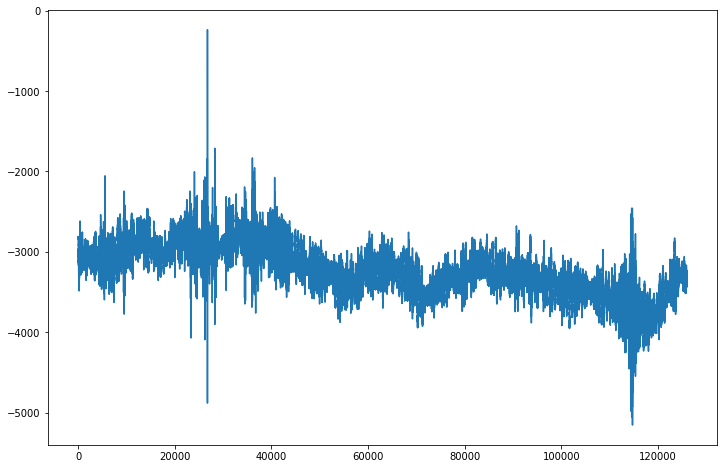

In [31]:
#X_raw = pd.read_hdf('../processed-data/new/raw_X_train_1_to_4_with_basic.hdf')
plt.figure(figsize=(12,8))
plt.plot(X_raw.loc[:20].to_numpy().reshape(-1))

In [31]:
X_train_plot = X_train[:X_train_raw.shape[0]]
y_train_plot = y_train[:X_train_raw.shape[0]]

def plot_alt(data_index):
    time_window = X_train_raw[data_index]
    print("Features: ", X_train[data_index])
    print("Date: ", times_plot[data_index])
    
    #earthquake_times = catalog_train["origintime"][(catalog_train["origintime"] >= date) &\
    #                                              (catalog_train["origintime"] <= pd.to_datetime(date + pd.to_timedelta(TIME_WINDOW, unit='s')))]
    
    # Number of samplepoints
    N = 6000

    # sample spacing
    T = 1.0 / 200

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    #title = "Earthquake time window" if earthquake else "Not earthquake time window"
    #plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
   # for eq_time in earthquake_times.values:
   #     second = (eq_time - date) / np.timedelta64(1,'s') * sps
   #     axs[0].axvline(second, color='r')
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    yf = 2.0/N * np.abs(yf[:N//2])
    
    axs[1].plot(xf, yf)
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 
print("Not earthquake")
plot_alt(np.random.choice(np.where(y_train_plot == 0)[0]))
print("Earthquake")
plot_alt(np.random.choice(np.where(y_train_plot ==1)[0]))

Not earthquake
Features:  [  5.70210000e+04   0.00000000e+00   3.12278589e-02   5.10912338e-02
   7.15702042e-02   1.54231688e-01   7.39395978e-02   8.23972063e-02]


NameError: name 'times_plot' is not defined

In [110]:
y_train_plot.shape

(86399,)

In [105]:
np.random.choice(np.where(y_train == 0)[0])

44063

In [93]:
def get_window_timestamp(date):
    seconds_to_hq = (pd.to_datetime(date) - start_time_train).total_seconds()
    
    time_window = X_train[int(seconds_to_hq * sps / spw), :]
    
    return time_window

def plot_window_time_and_fft(data_index, date, earthquake):
    time_window = X_train_raw[data_index]
    print("Features: ", X_train[data_index])
    print("Date: ", date)
    
    earthquake_times = catalog_train["origintime"][(catalog_train["origintime"] >= date) &\
                                                   (catalog_train["origintime"] <= pd.to_datetime(date + pd.to_timedelta(TIME_WINDOW, unit='s')))]
    
    # Number of samplepoints
    N = 6000

    # sample spacing
    T = 1.0 / 200

    x = np.arange(np.shape(time_window)[0])
    y = time_window - np.mean(time_window)

    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    yf = np.fft.fft(y)
    y_amplitudes = 2.0/N * np.abs(yf[:N//2])

    _, axs = plt.subplots(ncols=2, figsize=(20,8))
    title = "Earthquake time window" if earthquake else "Not earthquake time window"
    plt.suptitle(title, fontsize=18)
    
    # Plot time
    axs[0].plot(x, y)
    for eq_time in earthquake_times.values:
        second = (eq_time - date) / np.timedelta64(1,'s') * sps
        axs[0].axvline(second, color='r')
    axs[0].set_title("Time plot for time window", fontsize=18)
    axs[0].set_xlabel("Time", fontsize=13)
    axs[0].set_ylabel("Value", fontsize=13)
    
    # Plot frequency
    yf = 2.0/N * np.abs(yf[:N//2])
    
    axs[1].plot(xf, yf)
    axs[1].set_title("FFT plot for time window", fontsize=18)
    axs[1].set_xlabel("Frequency", fontsize=13)
    axs[1].set_ylabel("Amplitude", fontsize=13)
    
    plt.show() 

In [25]:
earthquake_indices

array([  20,  180,  188,  196,  207,  221,  251,  281,  372,  384,  397,
        410,  429,  819,  906,  913,  926, 1030, 1188, 1192, 1238, 1320,
       1422, 1432, 1471, 1534, 1576, 1717, 1844, 1918])

Features:  [ 209.            0.42583682   42.03334942   55.64337809   25.69480258
  181.98554261  107.7716021 ]
Date:  2018-04-09T18:36:00.000000000


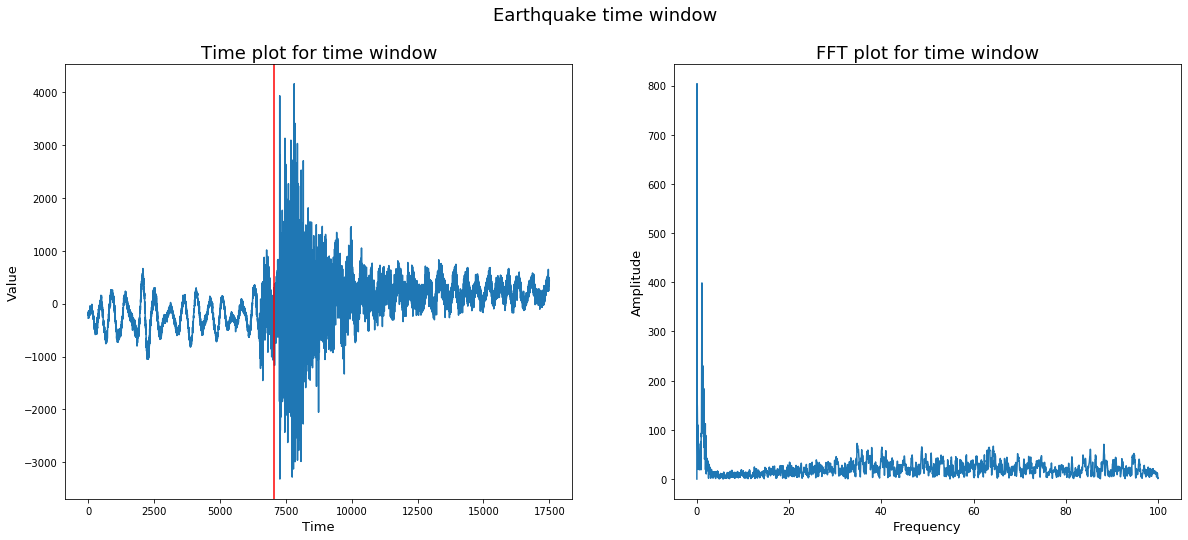

Features:  [  0.00000000e+00   5.96498987e-02   5.67974728e+00   1.62367363e+01
   2.93195213e+00   2.07002138e+02   8.88667881e+01]
Date:  2018-04-11T08:12:00.000000000


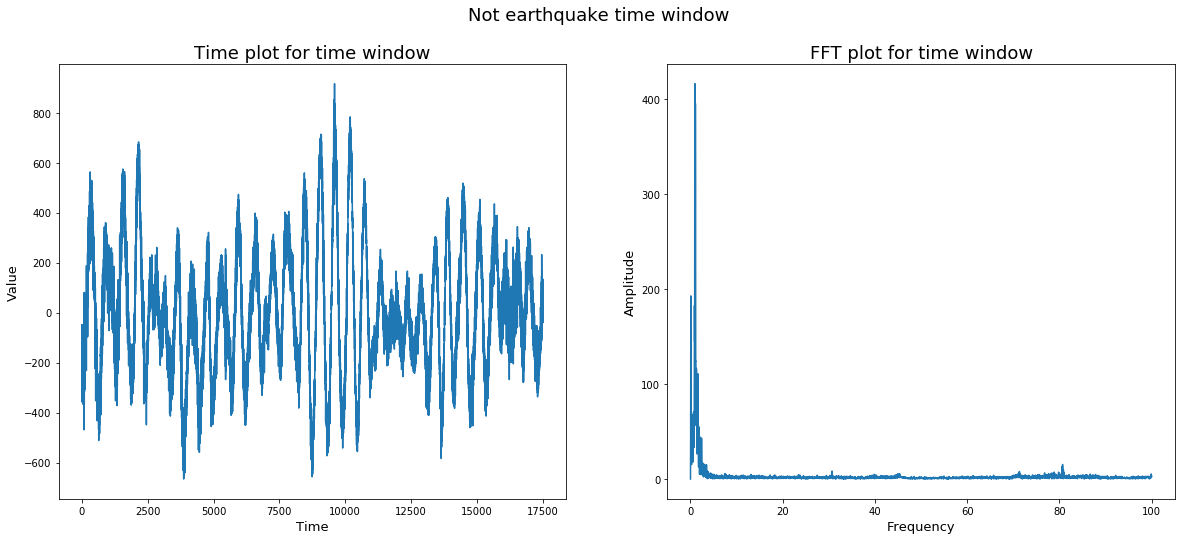

Features:  [  48.            0.38766847   16.09838251   31.19296187   16.5315553
  154.54030322   83.66036919]
Date:  2018-04-09T09:00:00.000000000


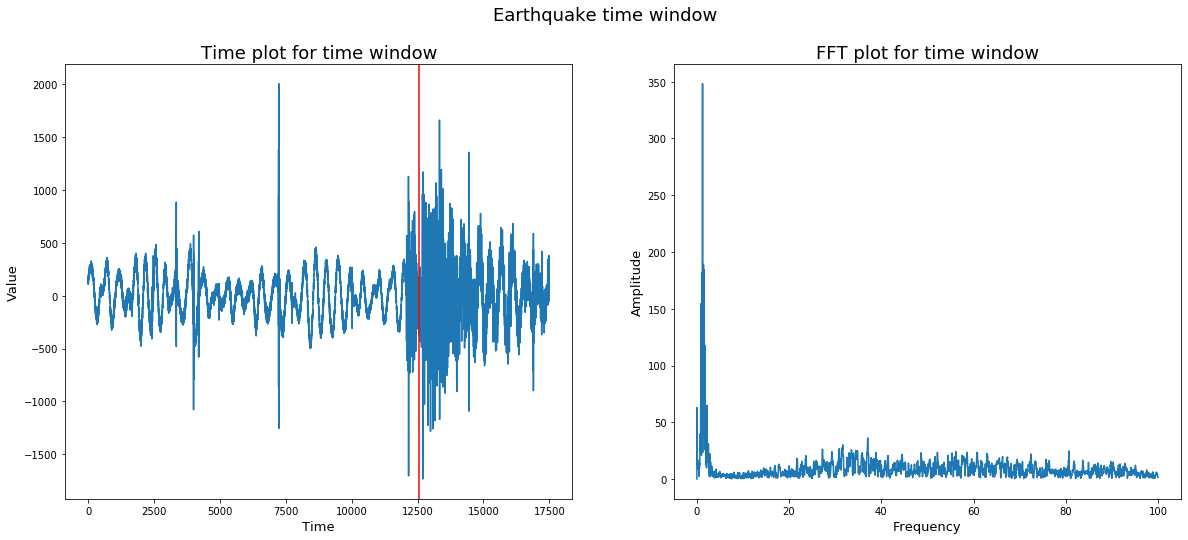

Features:  [ 188.            0.45322516   12.62822961   19.01159194   11.76716593
   67.52032421   44.49966131]
Date:  2018-04-12T21:33:00.000000000


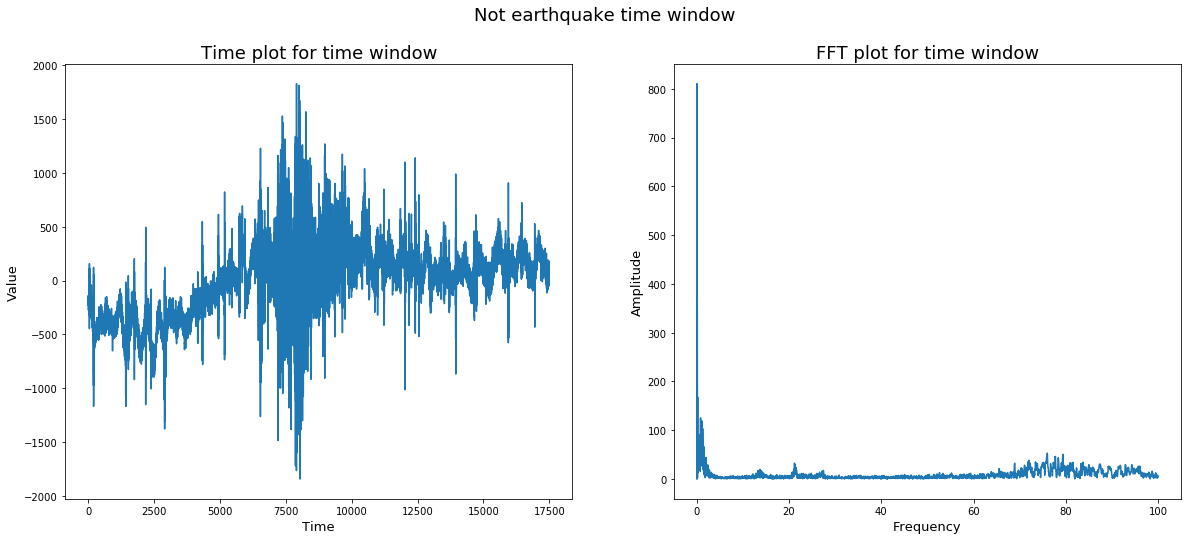

Features:  [  73.            0.32466295   10.22799125   21.3792587     5.72062287
  216.99557834   90.04468205]
Date:  2018-04-11T11:24:00.000000000


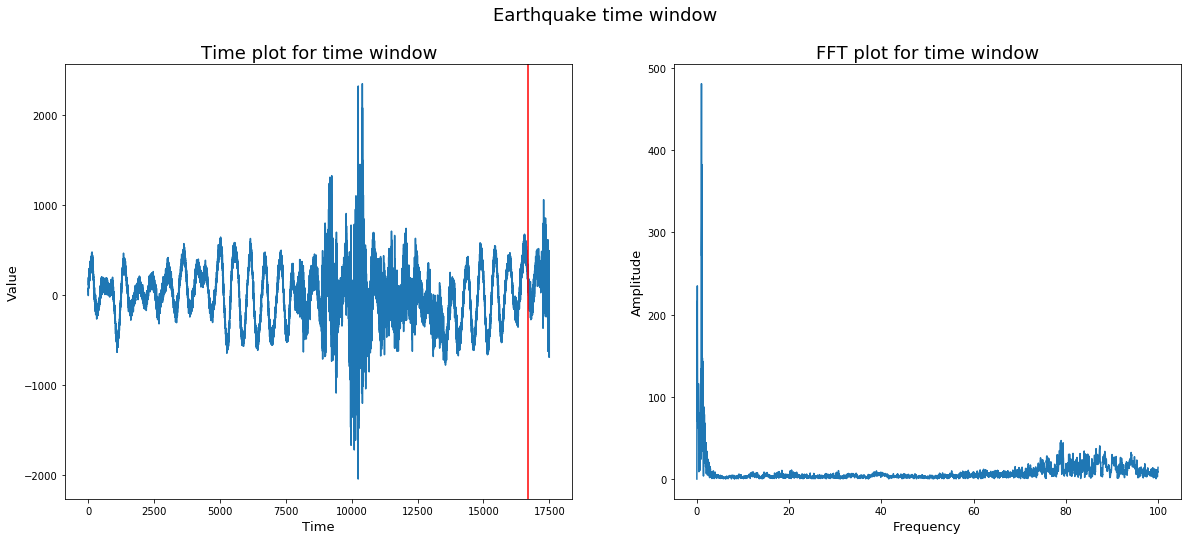

Features:  [  86.            0.19352195   13.90152397   28.66091471    7.08200521
  188.22503387  106.5786264 ]
Date:  2018-04-09T18:54:00.000000000


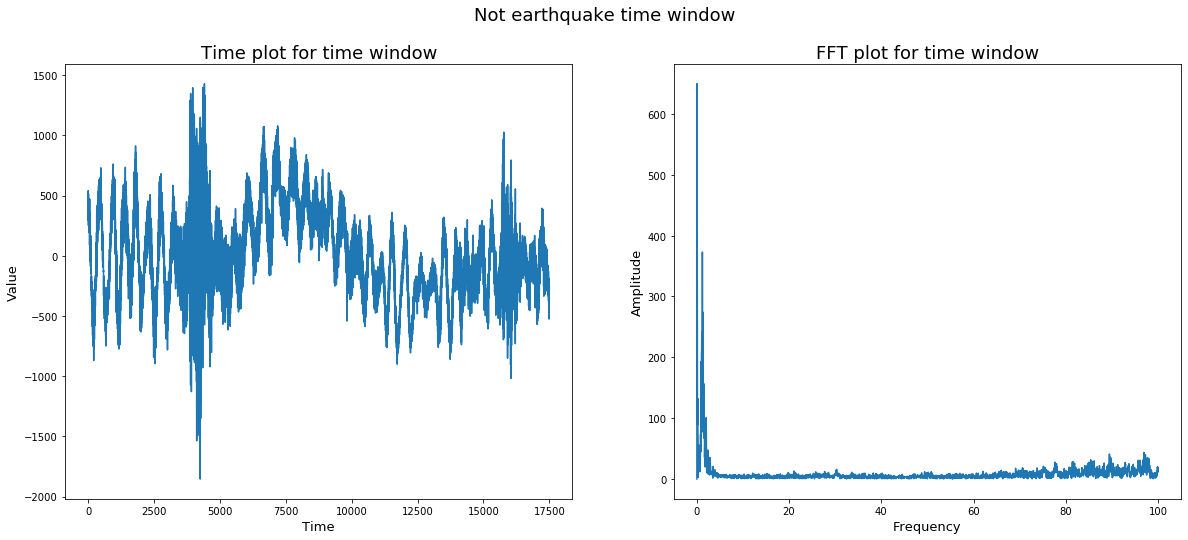

Features:  [ 433.            3.20083843  118.30015051  137.59846448   95.12691057
   82.45791484  113.76669836]
Date:  2018-04-12T01:33:00.000000000


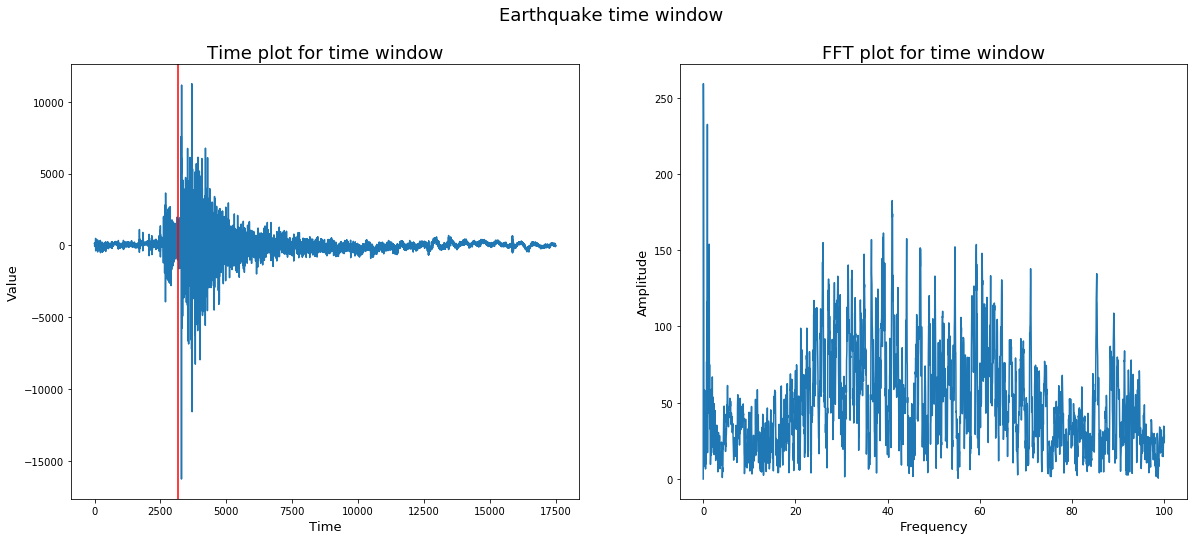

Features:  [  0.00000000e+00   7.14097734e-02   4.84019265e+00   1.06113175e+01
   2.79578843e+00   8.58250122e+01   4.67050072e+01]
Date:  2018-04-12T06:09:00.000000000


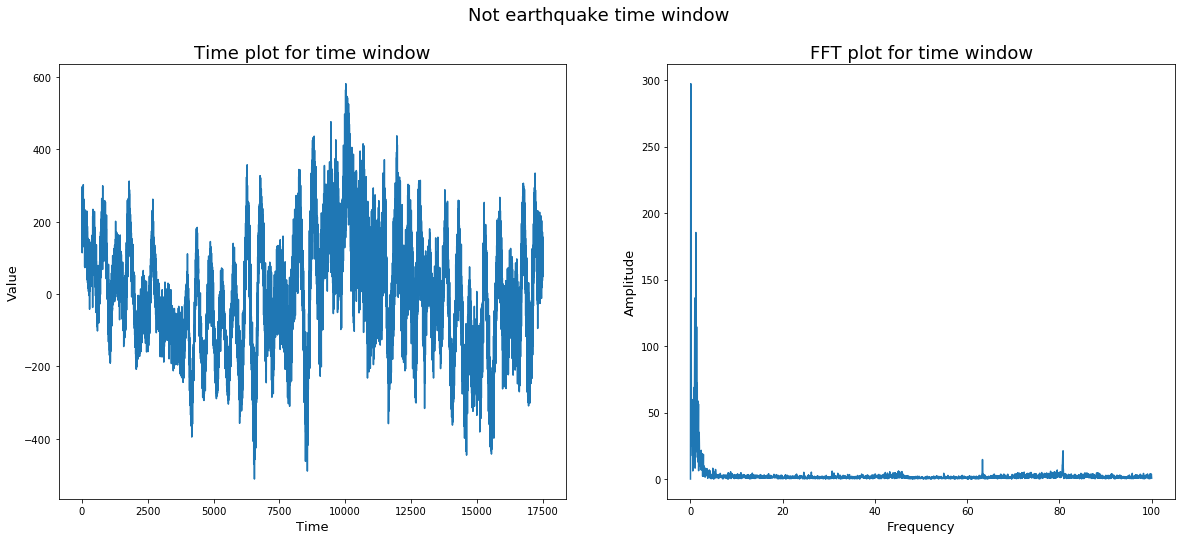

In [26]:
nm_plots = 4

eqs = np.random.choice(len(earthquake_times), nm_plots, replace=True)
not_eqs = np.random.choice(len(not_earthquake_times), nm_plots, replace=False)

stats = pd.DataFrame()
for i, (eq, not_eq) in enumerate(list(zip(eqs, not_eqs))):
    plot_window_time_and_fft(earthquake_indices[eq], earthquake_times[eq], True)
    plot_window_time_and_fft(not_earthquake_indices[not_eq], not_earthquake_times[not_eq], False)